# Maestría en Física Médica - Taller de Informática


# Imágenes médicas - DICOM 3D

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pydicom

ModuleNotFoundError: No module named 'pydicom'

### Abrir un archivo DICOM

In [2]:
DCM = pydicom.dcmread(r'../Assets/CT/IM-0001-0200-0001.dcm')

NameError: name 'pydicom' is not defined

In [3]:
type(DCM)

NameError: name 'DCM' is not defined

In [4]:
DCM

NameError: name 'DCM' is not defined

Para acceder a cada uno de los atributos del archivo DICOM se utiliza el nombre del atributo

In [5]:
DCM.PatientName

NameError: name 'DCM' is not defined

In [6]:
DCM.StudyDescription

NameError: name 'DCM' is not defined

In [7]:
DCM.ProtocolName

NameError: name 'DCM' is not defined

Pero también tengo la información desde el tag, usando el grupo y elemento en representación hexadecimal:

In [8]:
print("Tag  : ",DCM[0x0018,0x1030].tag)
print("VR   : ",DCM[0x0018,0x1030].VR)
print("valor: ",DCM[0x0018,0x1030].value)

NameError: name 'DCM' is not defined

#### Ventanas de visualización típicas en CT

- Cabeza y cuello
    - cerebro w:80 c:40
    - subdural w:130-300 c:50-100
    - acv w:8 c:32 / w:40 c:40
    - hueso w:2800 c:600
    - Tejido blando: w:350–400 c:20–60
    
- Pecho
    - Pulmones w:1500 c:-600
    - Mediastino w:350 c:50
    
- Abdomen
    - Tejido blando w:400 c:50
    - Hígado w:150 c:30

- Columna
    - Tejido blando w:250 c:50
    - Hueso w:1800 c:400


## Reconstrucción multiplanar

Las tomografías son un conjunto de imágenes (cortes, slices) que se adquieren en un mismo acto de diagnóstico. Es por ello que permiten realizar reconstrucciones, esto es, obtener una imagen en cualquier plano que intersecte el volumen tomográfico relevado. 

Usualmente se estila utilizar los cortes tranversales, coronales y sagitales para analizar la imagen.



### 1 Cargar todos los cortes de la tomografía

Para poder realizar una reconstrucción, es necesario contar con todos los cortes tomográficos. Para ellos vamos a usar el módulo `glob`, que permite acceder a la información completa de un directorio en nuestra computadora.

In [9]:
import glob

directorio = '../Assets/CT/*.dcm'

archivos = glob.glob(directorio, recursive=False)

print(type(archivos))
print(archivos[0:10])
print(len(archivos))


<class 'list'>
[]
0


Se puede ver que `glob.glob` devuelve en `archivos` una lista de los archivos en el directorio. Sin embargo, la lista de archivos está desordenada. Para ello, tenemos que hacer un paréntesis y analizar cómo ordenar la lista.

#### *Intermezzo*: sort y mutabilidad 

Python, por supuesto, nos brinda la función `sorted` que puede ordenar una lista. Pero también nos da el método `sort` que reordena una lista. ¿Cuál es la diferencia? Veamos: 


In [10]:
a = [3,4,1,5]
b = sorted(a,reverse = True)
print(b)

[5, 4, 3, 1]


In [11]:
c = ['monoambiente', 'casa', 'departamento']
print(c)
b = c.sort()
print(b)
print(c)

['monoambiente', 'casa', 'departamento']
None
['casa', 'departamento', 'monoambiente']


In [12]:
def largo(palabra):
    """
        función de ordenamiento, recibe un sólo argumento
        y retorna un solo valor, correspondiente al criterio 
        de ordenamiento de la lista
    """
    return len(palabra)


print(largo('hola'))

c = ['monoambiente', 'casa', 'departamento','posada']
print(c)
b = sorted(c)
print("c ordenado alfabéticamente: ",b)
d = sorted(c,key=largo)
print("c ordenado por largo de palabra: ",d)
f = sorted(c,key=largo,reverse=True)
print("c ordenado por largo de palabra, inverso: ",f)



4
['monoambiente', 'casa', 'departamento', 'posada']
c ordenado alfabéticamente:  ['casa', 'departamento', 'monoambiente', 'posada']
c ordenado por largo de palabra:  ['casa', 'posada', 'monoambiente', 'departamento']
c ordenado por largo de palabra, inverso:  ['monoambiente', 'departamento', 'posada', 'casa']


> Mientras que `sorted` devuelve una lista ordenada, `sort` reordena la lista en sí misma

En este sentido, decimos que `sort` es una función que *muta* una variable en su mismo lugar (en inglés, *in place*). Por otro lado, `sorted` no cambia la variable de entrada de la función, y retorna una nueva variable.

#### *Fin intermezzo*

Volviendo a nuestro ejemplo con los archivos

In [13]:
archivos_ordenados = sorted(archivos)
print(archivos_ordenados[0:10])

[]


In [14]:
dicoms = []
for fname in archivos_ordenados:
    dicoms.append(pydicom.read_file(fname))

print("Número de cortes tomográficos:",len(dicoms))

Número de cortes tomográficos: 0


Ahora nuestra lista `dicom` contiene los datos DICOM de **todos** los cortes tomográficos. Veamos si es así:

In [15]:
n_cts = len(dicoms)

for (i,dcm) in zip(range(0,n_cts),dicoms):
    print("Paciente en el corte ",i, ":", dcm.PatientName)

Es claro que todos los cortes deben tener el mismo nombre de paciente. Hay otros datos dicom que cambian de acuerdo al corte tomográfico, por ejemplo:

In [16]:
for (i,dcm) in zip(range(0,n_cts),dicoms):
    print("Posición del corte ",i, ":", dcm.SliceLocation, " mm")

#### 2 Construcción del volumen tomográfico

Convencidos de que tenemos efectivamente la información DICOM en nuestra lista, ahora debemos recuperar la imagen de cada corte, y construir un volumen con ellas. Para eso vamos a usar un arreglo 3D de `numpy`.


In [17]:
slice0 = dicoms[0]   # Primer corte, lo uso para recuperar los datos comunes a todos los cortes
vol_shape = list(slice0.pixel_array.shape) # Tamaño de la imagen 2D
print(vol_shape)
vol_shape.append(len(dicoms))   # Agregamos a la lista el tamaño de la imagen a lo largo de z
# Si tenemos poca RAM, podemos fijar la cantidad de cortes en el eje z
# vol_shape.append(100)   # Agregamos a la lista el tamaño de la imagen a lo largo de z

print(vol_shape)

matriz3D = np.zeros(vol_shape)
print(matriz3D.shape)

IndexError: list index out of range

Ya tenemos nuestro volumen tomográfico listo para ser llenado con las imágenes:

In [18]:
# Si tenemos poca RAM, podemos leer sólo los cortes que queremos,acorde
# a la cantidad de cortes que definimos antes
# for i, slice in enumerate(dicoms[100:200]):

for i, slice in enumerate(dicoms):

    corte = slice.pixel_array * slice.RescaleSlope + slice.RescaleIntercept
    matriz3D[:, :, i] = corte

#### 3 Extracción de imágenes

NameError: name 'matriz3D' is not defined

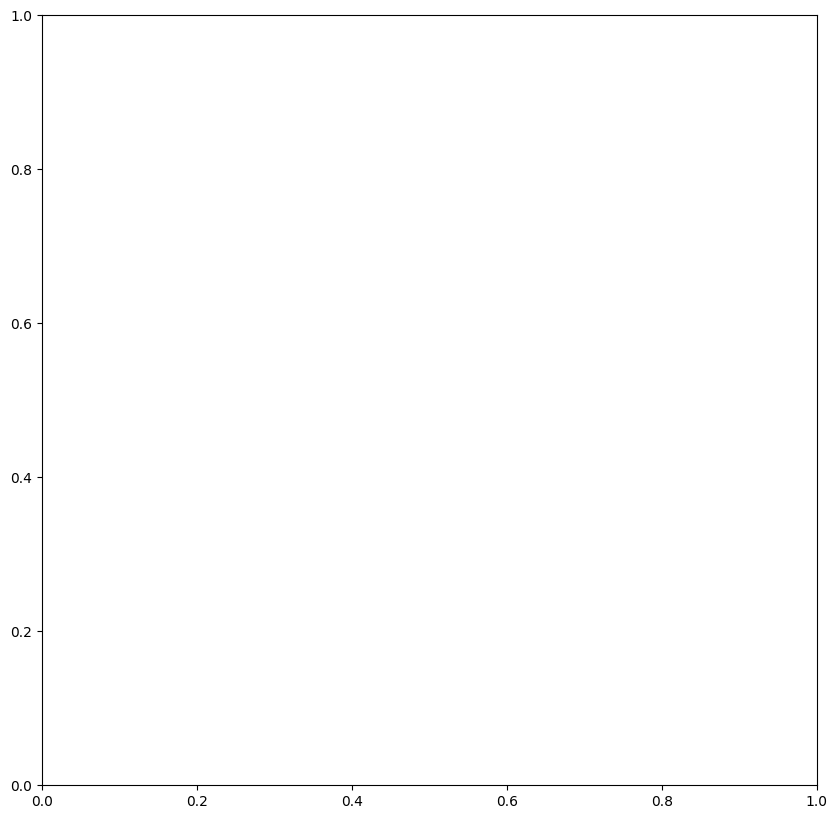

In [19]:
#
#   Window and level
#
c = 40
w = 400
ventmax = c + w/2
ventmin = c - w/2


fig_1 = plt.figure(1, figsize=(10,10))
a1 = fig_1.add_subplot(111)
a1.imshow(matriz3D[255, :, :].T, cmap='gray', vmin=ventmin, vmax=ventmax)
plt.show()


#### 4 Relación de aspecto

Como puede verse,la imagen aparece 'aplastada' en la dirección longitudinal. Esto se debe a que **los vóxeles no son isotrópicos** en CT, es decir, no tienen las mismas dimensiones:

In [20]:
espaciadoX,espaciadoY = slice0.PixelSpacing
espesor = slice0.SliceThickness
print('El espesor de corte es de: {:.2f} mm'.format(espesor))
print('La dimension en el plano X,Y es de {:.2f} mm x {:.2f} mm '.format(espaciadoX,espaciadoY))

NameError: name 'slice0' is not defined

Con estos datos podemos definir la relación de aspecto entre el eje Z y el eje X (o Y):

$$
\texttt{AspectRatio} = \frac{\texttt{PixelSpacing}}{\texttt{SliceThickness}}
$$

In [21]:
aspecto = espesor/espaciadoX
print("Relación de aspecto:",aspecto)
fig_1 = plt.figure(1, figsize=(15,15))
a1 = fig_1.add_subplot(111)
a1.imshow(matriz3D[280, :, :].T, cmap='gray', vmin=ventmin, vmax=ventmax)
a1.set_aspect(aspecto)
a1.set_title('MPR CORONAL')
plt.show()

NameError: name 'espesor' is not defined


### Una cosa más...

> **No siempre el orden de los nombres de los archivos DICOM de una CT corresponde con el orden a lo largo del eje Z !!!**

En efecto, bien podría ser que al ordenar los archivos por su nombre, como hicimos más arriba, los cortes tomográficos queden desordenados. 

Por suerte, como vimos antes, `sorted` viene al rescate.

In [22]:
help(sorted)

Help on built-in function sorted in module builtins:

sorted(iterable, /, *, key=None, reverse=False)
    Return a new list containing all items from the iterable in ascending order.

    A custom key function can be supplied to customize the sort order, and the
    reverse flag can be set to request the result in descending order.



La función `sorted` puede recibir en forma opcional una función que se utilice para ordenar la lista, en el parámetro `key`.

En nuestro caso, la función que necesitamos es aquella que nos devuelve el valor de `SliceLocation`, que efectivamente indica la posición del corte a lo largo del eje Z.

In [23]:
def z_mm(archivo):
    dcm = pydicom.read_file(archivo)
    return dcm.SliceLocation

z_mm('../Assets/CT/IM-0001-0145-0001.dcm')

NameError: name 'pydicom' is not defined

In [24]:
print(archivos[0:10])

[]


In [25]:
archivos_reordenados = sorted(archivos,key = z_mm, reverse = True)
print(archivos_reordenados[0:10])

[]


In [26]:
dicoms = []
for fname in archivos_reordenados:
    dicoms.append(pydicom.read_file(fname))

print("Número de cortes tomográficos:",len(dicoms))

Número de cortes tomográficos: 0


In [27]:
for i, slice in enumerate(dicoms):
    corte = slice.pixel_array * slice.RescaleSlope + slice.RescaleIntercept
    matriz3D[:, :, i] = corte

In [28]:
aspecto = espesor/espaciadoX
print("Relación de aspecto:",aspecto)
fig_1 = plt.figure(1, figsize=(15,15))
a1 = fig_1.add_subplot(111)
a1.imshow(matriz3D[280, :, :].T, cmap='gray', vmin=ventmin, vmax=ventmax)
a1.set_aspect(aspecto)
a1.set_title('MPR CORONAL')
plt.show()

NameError: name 'espesor' is not defined